# Expected error probabilities of Clarke maximum a posteriori strategies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb, binom
from scipy.stats import multinomial

In [2]:
# box and measurement parameters
N = 1 # half number of photons per box
n = np.arange(2*N+1)

In [3]:
def multinomial(lst):
    res, i = 1, sum(lst)
    i0 = lst.index(max(lst))
    for a in lst[:i0] + lst[i0+1:]:
        for j in range(1,a+1):
            res *= i
            res //= j
            i -= 1
    return res

def likelihood( n1, n2 , N = 1 , box = "A"):

    P = np.zeros( (len(n1) , len(n2)) , dtype="float64")
    
    if box == "C":
        for j in range(len(n1)):
            C = np.power( np.sqrt(2) - 1 , n1[j])*np.power( 0.5*(2 - np.sqrt(2)) , 2*N - n1[j])
            for k in range(len(n2)):
                if n1[j] + n2[k] <= 2*N:
                    P[j,k] += C*binom( n1[j] + n2[k], n1[j])*binom( 2*N , 2*N - n1[j] - n2[k])
    else:
        
        p0 = 1/np.sqrt(2)  # P1|H , P1|L
        p1 = 1 - p0 # P2|H , P3|L
        
        q1 = 0.5*(2 - np.sqrt(2)) # P2|V , P3|R
        q2 = 2*q1 # P2|R , P3|V
        q0 = 1 - q1 - q2 # P1|V , P1|R
        
        if box == "A":
            for j in range(len(n1)):
                for k in range(len(n2)):
                    if n1[j] + n2[k] <= 2*N:
                        nmin = np.maximum(0, n1[j]-N)
                        nmax = np.minimum(n1[j], N)
                        for n in range(nmin, nmax + 1):
                            C = binom(N , n)*binom(2*N - n - n2[k], 2*N - n1[j] - n2[k])*binom(N, n2[k] + n - N)
                            #C = binom(N , n)*binom(n1[j] + n2[k] - N , n1[j] - n)*binom(N, 2*N - n1[j] - n2[k])
                            C *= np.power(p0 , n)*np.power(p1 , N-n)
                            P[j, k] += C*np.power(q0 , n1[j] - n)*np.power(q1, n2[k] + n - N)*np.power(q2, 2*N - n1[j] - n2[k])##
                    
        if box == "B":
            for j in range(len(n1)):
                for k in range(len(n2)):
                    if n1[j] + n2[k] <= 2*N:
                        nmin = np.maximum(0, n1[j]-N)
                        nmax = np.minimum(n1[j], N)
                        for n in range(nmin, nmax + 1):
                            C = binom(N , n)*binom(n1[j] + n2[k] - n, n2[k])*binom( N , N + n - n1[j] - n2[k] )
                            C *= np.power(p0 , n)*np.power(p1 , N-n)
                            P[j, k] += C*np.power(q0 , n1[j] - n)*np.power(q1, N + n - n1[j] - n2[k])*np.power(q2, n2[k]) ##
    
    return P

def EEP( LHA, LHB, LHC ): # expected error probability
    
    # inferring events when the maximum likelihood is well defined
    Ainfer_event = (LHA>LHB)*(LHA>LHC)
    Binfer_event = (LHB>LHA)*(LHB>LHC)
    Cinfer_event = (LHC>LHA)*(LHC>LHB)
    
    ABcoincidence = (LHA==LHB)*(LHA>LHC)
    ACcoincidence = (LHA==LHC)*(LHA>LHB)
    BCcoincidence = (LHB==LHC)*(LHB>LHA)
    
    ABCcoincidence = (LHA==LHB)*(LHA==LHC)
    
    # EXPECTED CONDITIONAL SUCCESS PROBABILITIES
    ESPA = LHA[Ainfer_event].sum() # when the maximum likelihood is evidently A, infer A correctly
    ESPA += LHA[ABcoincidence].sum()/2+LHA[ACcoincidence].sum()/2. # when two likelihoods are equal, throw a dice
    ESPA += LHA[ABCcoincidence].sum()/3 # when the three likelihoods are equal, throw a three sided dice
    
    ESPB = LHB[Binfer_event].sum() # when the maximum likelihood is evidently B, infer B correctly
    ESPB += LHB[ABcoincidence].sum()/2+LHB[BCcoincidence].sum()/2. # when two likelihoods are equal, throw a dice
    ESPB += LHB[ABCcoincidence].sum()/3 # when the three likelihoods are equal, throw a three sided dice
    
    ESPC = LHC[Cinfer_event].sum() # when the maximum likelihood is evidently C, infer C correctly
    ESPC += LHC[ACcoincidence].sum()/2+LHC[BCcoincidence].sum()/2. # when two likelihoods are equal, throw a dice
    ESPC += LHC[ABCcoincidence].sum()/3 # when the three likelihoods are equal, throw a three sided dice
    
    EEP_dict = {
        "A": 1 - ESPA,
        "B": 1 - ESPB,
        "C": 1 - ESPC,
        "Overall": 1 - (ESPA+ESPB+ESPC)/3.
    }
    
    return EEP_dict

In [4]:
LHA = likelihood( n , n , N, "A")
LHB = likelihood( n , n , N, "B")
LHC = likelihood( n , n , N, "C")

np.save("ClarkeLikelihood_BoxA_N{:d}".format(2*N), LHA)
np.save("ClarkeLikelihood_BoxB_N{:d}".format(2*N), LHB)
np.save("ClarkeLikelihood_BoxC_N{:d}".format(2*N), LHC)

In [5]:
N1 , N2 = np.meshgrid( n ,  n )

print( (N1.T*LHA).sum(), (N2.T*LHA).sum() )
print( (N1.T*LHB).sum(), (N2.T*LHB).sum() )
print( (N1.T*LHC).sum(), (N2.T*LHC).sum()  )

0.8284271247461902 0.585786437626905
0.8284271247461902 0.5857864376269049
0.8284271247461903 0.5857864376269049


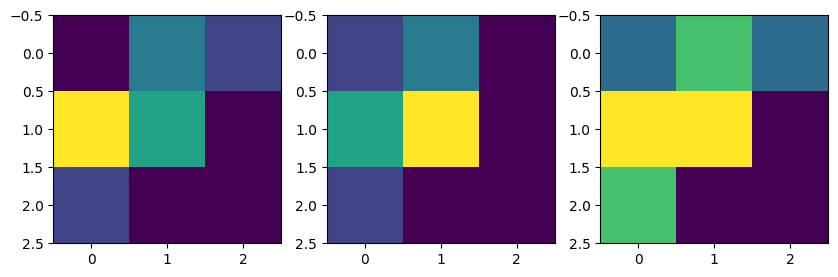

In [6]:
fig, ax = plt.subplots( 1 , 3 , figsize=(10,4) )
ax[0].imshow(LHA)
ax[1].imshow(LHB)
ax[2].imshow(LHC)

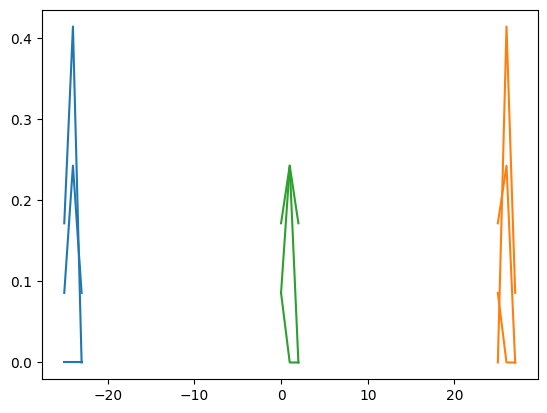

In [9]:
#plt.plot(np.arange(2*N), LHA, color="C0")
#plt.plot(np.arange(2*N), LHB, color="C1")
plt.plot(n, LHC, color="C2")
plt.plot(25+n, LHA, color="C1")
plt.plot(-25+n, LHB, color="C0")
plt.show()

# For varying values of N

In [10]:
N = np.arange(50+1)

for j in range(len(N)):
    print(N[j])
    n = np.arange(2*N[j]+1)
    LHA = np.round(likelihood( n , n , N[j], "A"), 12)
    LHB = np.round(likelihood( n , n , N[j], "B"), 12)
    LHC = np.round(likelihood( n , n , N[j], "C"), 12)
    
    EEPs = np.array(list(EEP(LHA,LHB,LHC).values()))
    np.save("3BPClarkeMAPEEP_N{:d}.npy".format(2*N[j]), EEPs)
    
#np.save("3BPClarkeMAPEEP_Nmax{:d}.npy".format(2*Nmax), EEPs)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
